
## Data preparation and target design


In [218]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from plotnine import *

warnings.filterwarnings("ignore")


# Import data

In [220]:
data = pd.read_csv("C:/Users/behna/Desktop/Assignment 3/cs_bisnode_panel.csv")

In [111]:
# drop variables with many NAs
data = data.drop(
    columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)

data = data[(data["year"] >= 2010) & (data["year"] <= 2015)]


# Label engineering


In [113]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN


In [114]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

# defaults in two years if there are sales in this year but no sales two years later
# Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-2) == 0)
).astype(int)


In [115]:
#data = data.query("year <= 2013")


In [118]:
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)  # has to be outside of assin()
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)


In [119]:
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")[
    "sales_mil_log"
].shift(1)


In [120]:
# replace w 0 for new firms + add dummy to capture it
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)


In [121]:
data["new"].describe()


count    236250.000000
mean          0.563319
std           0.495976
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64

# Feature engineering

In [236]:
data["ind2"].unique()

array([56., 27., 33., 55., 29., 41., 32., 28., 30., 96., nan, 26., 68.,
       47., 73., 62., 46., 71., 82., 66., 45., 25., 43., 10., 95.,  1.,
       74., 70., 92., 63., 90., 81., 14., 69., 93., 52., 87., 79., 22.,
       16., 85., 72., 42., 49., 64., 58., 11., 77., 61., 59.,  2., 31.,
       78., 13., 84., 15., 86., 37., 24., 23., 80., 36., 91., 18., 35.,
       20., 17., 88., 94.])

In [128]:
# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])


In [129]:
data.groupby("ind2_cat").count()["comp_id"]


ind2_cat
20.0      390
26.0     8073
27.0     4956
28.0    13984
29.0     2390
30.0     1398
32.0      935
33.0    13109
35.0        5
40.0     1572
55.0    19973
56.0    98772
60.0     1990
99.0    68703
Name: comp_id, dtype: int64

In [130]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")


In [131]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]


flag_asset_problem
0.0    167432
1.0       117
Name: comp_id, dtype: int64

In [132]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])


In [133]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()


count    1.675490e+05
mean     4.758193e+05
std      8.756906e+06
min      0.000000e+00
25%      3.781481e+03
50%      1.740741e+04
75%      7.868519e+04
max      2.706026e+09
Name: total_assets_bs, dtype: float64

In [134]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]


In [135]:
# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)


In [136]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )


In [137]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)


In [138]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)


In [139]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)


In [140]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)


In [141]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)


In [142]:
data["labor_avg"].describe()


count    114260.000000
mean          0.969446
std           4.693914
min           0.000000
25%           0.090278
50%           0.234848
75%           0.548611
max         208.677078
Name: labor_avg, dtype: float64

In [143]:
data["labor_avg_mod"].describe()


count    236250.000000
mean          0.969446
std           3.264340
min           0.000000
25%           0.250000
50%           0.969446
75%           0.969446
max         208.677078
Name: labor_avg_mod, dtype: float64

In [144]:
data = data.drop(["labor_avg"], axis=1)


In [145]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])


In [146]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2


## How to design the target variable
Firm growth is a highly stochastic process, particularly for small and medium enterprises. Hence, one-year growth can be driven by random factors, making measures to have a more reliable account of the multi-year growth necessary. As also indicated in this dataset, high growth in one year often reverts in the following year. As a result we need to visit the literature in corporate finance to find a well-suited indicator to detect high growth companies. 

The literature on fast-growing firms features a wide array of definitions for high-growth firms. The most widely used benchmark is the Eurostat-OECD definition, which classifies a firm as high-growth if it has at least 10 employees at the beginning of a three-year period and achieves an average annual employment growth exceeding 20% during that time. However, applying this definition to our data resulted in a very small number of high-growth observations, leading to a highly imbalanced sample and poor model performance. Similar concerns about the OECD definition have been raised in prior studies.

To address this issue, some researchers—such as Hölzl (2009) and Hoxha (2008)—adopt a relative approach, identifying the top 5% of firms with the highest employment growth. Yet, when applying this method to our dataset, we encountered another challenge: employment data was among the noisiest variables, limiting its reliability for prediction.

A third stream of literature defines high-growth firms based on sales growth. For instance, Nicholls-Nixon (2005) considers companies fast-growing if they start with at least $100,000 in revenue and increase annual sales by at least 20% each year over four years. Similarly, Barringer and Jones (2004) define fast-growing firms as those with a three-year compound annual sales growth rate of at least 80%, while Siegel et al. (1993) use a 25% annual growth threshold sustained over at least three years.

Following this latter approach, we define high-growth firms as those with sales growth exceeding 20% annually over a three-year period. This criterion identifies approximately 6.6% of the observations in our dataset, which is consistent with other studies that define high-growth firms as the top 5–10% of performers based on sales growth.


In [148]:
def detect_high_growth_companies(data):
    """
    Detect companies with more than 5% sales growth for three consecutive years.
    
    Args:
        data: DataFrame containing comp_id, year, and sales columns
        
    Returns:
        DataFrame with companies meeting the growth criteria
    """
    # Sort data by company and year
    data = data.sort_values(['comp_id', 'year'])

    # Calculate year-to-year sales growth
    data['prev_sales'] = data.groupby('comp_id')['sales'].shift(1)
    data['sales_growth'] = (data['sales'] - data['prev_sales']) / data['prev_sales'] * 100  # in percentage

    # Create a column to track if a company had 3 consecutive years with more than 5% growth
    data['high_growth'] = 0  # Default to 0 (False) for all rows

    # Loop over each company
    for comp_id, group in data.groupby('comp_id'):
        growth_streak = 0
        for i in range(1, len(group)):
            if group['sales_growth'].iloc[i] > 20:
                growth_streak += 1
                if growth_streak >= 2:  # This means 3 consecutive years
                    data.loc[group.index[i], 'high_growth'] = 1  # Mark as 1 (True)
            else:
                growth_streak = 0

    return data

# Assuming `data` is your DataFrame
data = detect_high_growth_companies(data)


In [149]:
data[data["high_growth"] == True].shape

(9486, 117)

In [150]:
data.shape

(236250, 117)

In [151]:
percentage_high_growth = (data["high_growth"].sum() / len(data)) * 100
print(f"{percentage_high_growth:.2f}% of the observations have high_growth == True")

4.02% of the observations have high_growth == True


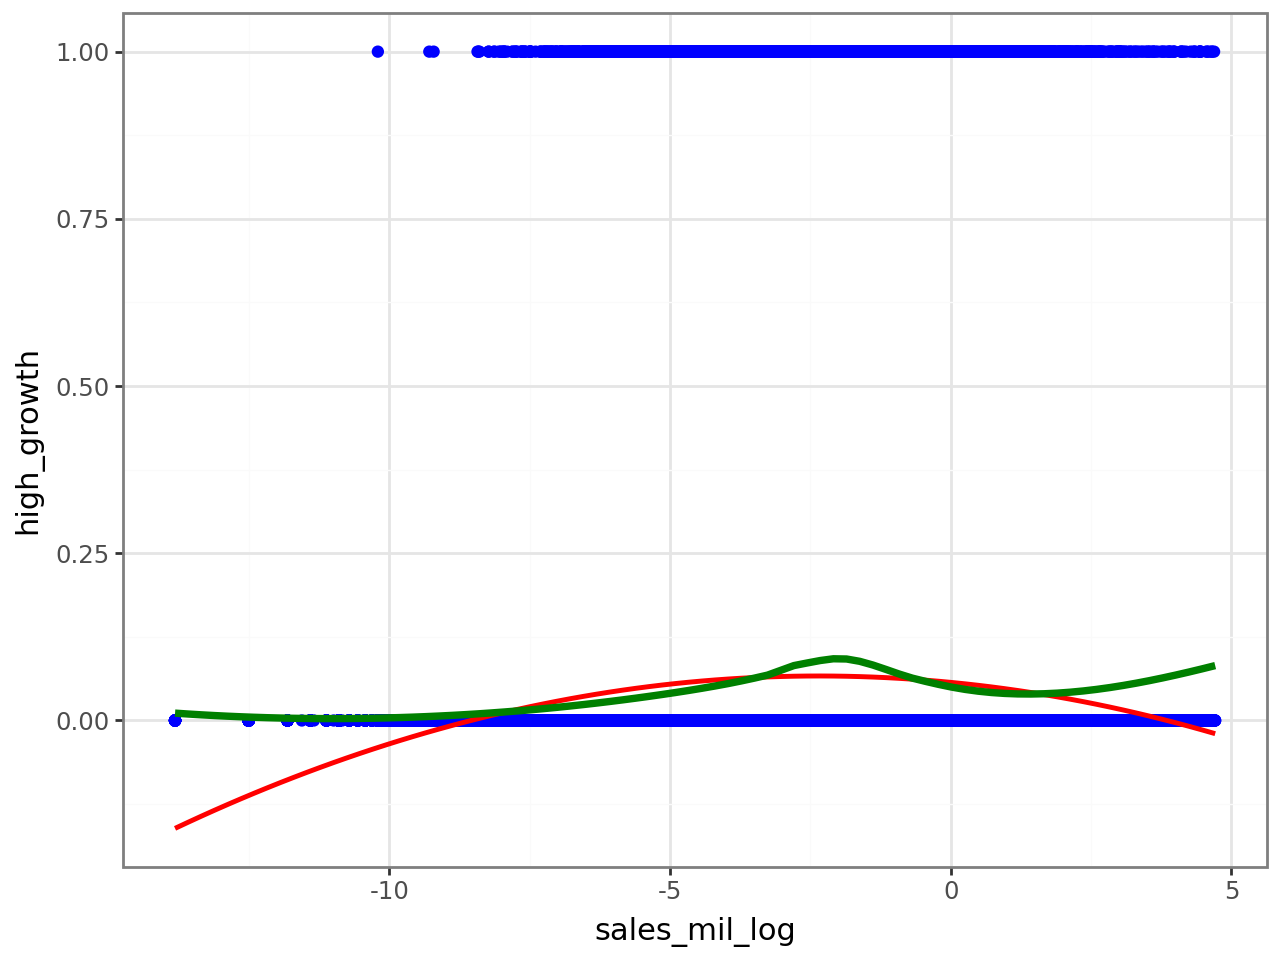

In [152]:
color = ["blue", "red", "green"]

(
    ggplot(data, aes(x="sales_mil_log", y="high_growth"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color=color[1], se=False)
    + geom_smooth(method="loess", color=color[2], se=False, size=1.5, span=0.9)
    + labs(x="sales_mil_log", y="high_growth")
    + theme_bw()
)


In [153]:
# Linear regressions
ols_s = smf.ols("high_growth ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())


                            OLS Regression Results                            
Dep. Variable:            high_growth   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     276.3
Date:                Sun, 06 Apr 2025   Prob (F-statistic):          1.63e-120
Time:                        12:47:30   Log-Likelihood:                 6091.0
No. Observations:              163864   AIC:                        -1.218e+04
Df Residuals:                  163861   BIC:                        -1.215e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0570      0.001  

In [154]:
########################################################################
# sales change
########################################################################
# Note: graphs not in book

# lowess
data["d1_sales_mil_log"].describe()


count    236250.000000
mean          0.047829
std           1.077472
min         -13.815511
25%           0.000000
50%           0.000000
75%           0.000000
max          13.815511
Name: d1_sales_mil_log, dtype: float64

(
    ggplot(data, aes(x="d1_sales_mil_log", y="high_growth"))
    + geom_point(color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="high_growth")
    + scale_x_continuous(limits=(-6, 10), breaks=seq(-5, 10, by=5))
    + theme_bw()
)


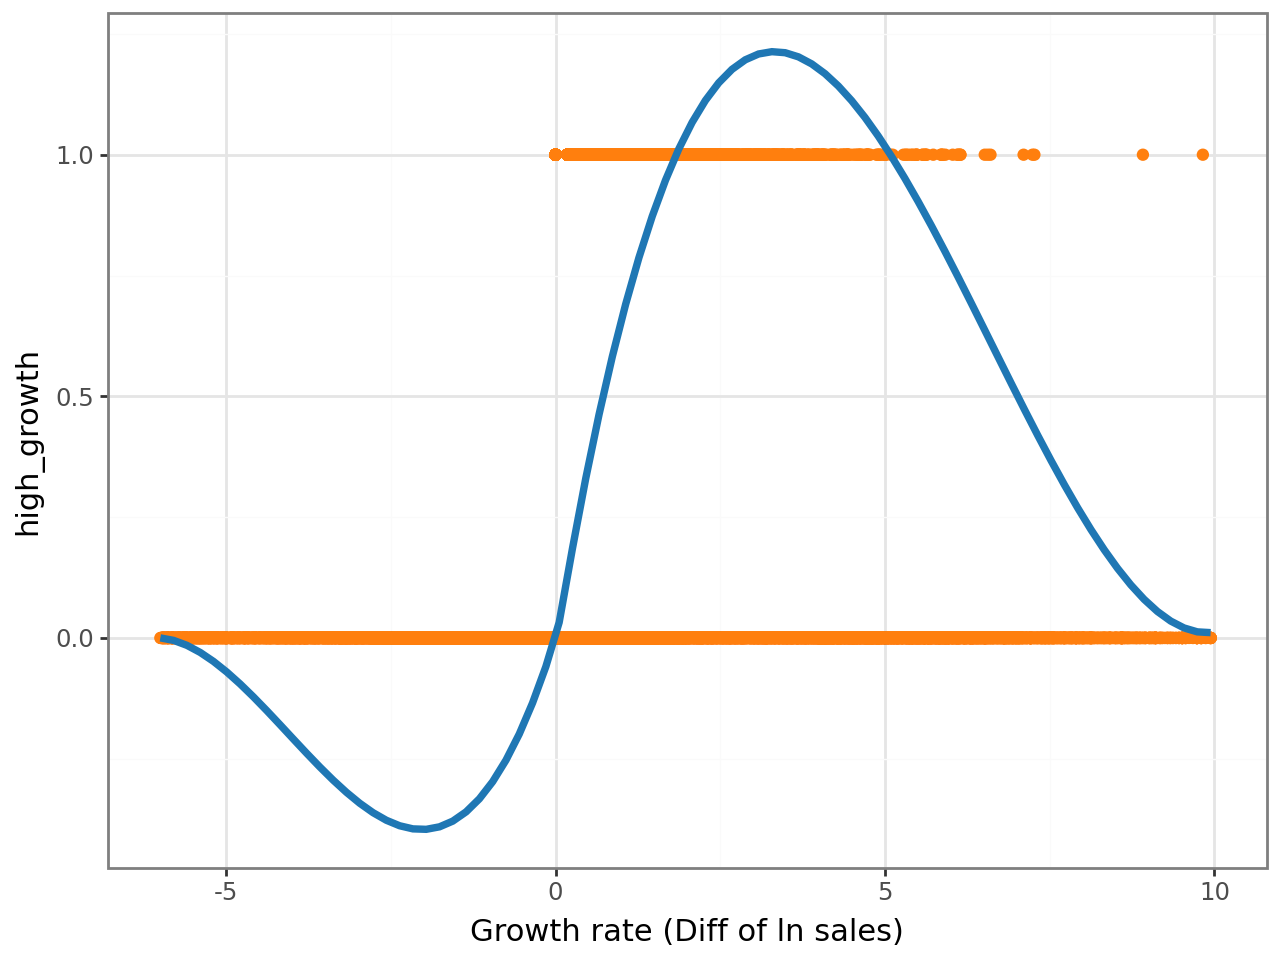

In [156]:
import numpy as np
from plotnine import ggplot, aes, geom_point, geom_smooth, labs, scale_x_continuous, theme_bw

color = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # You can define your color scheme here

(
    ggplot(data, aes(x="d1_sales_mil_log", y="high_growth"))
    + geom_point(color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="high_growth")
    + scale_x_continuous(limits=(-6, 10), breaks=np.arange(-5, 11, 5))  # Using np.arange here
    + theme_bw()
)


In [157]:
# generate variables ---------------------------------------------------

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2


In [158]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])


In [159]:
# drop missing
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
data["age"].describe()


count    135118.000000
mean          8.918871
std           7.069126
min           0.000000
25%           3.000000
50%           7.000000
75%          15.000000
max          63.000000
Name: age, dtype: float64

In [160]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()


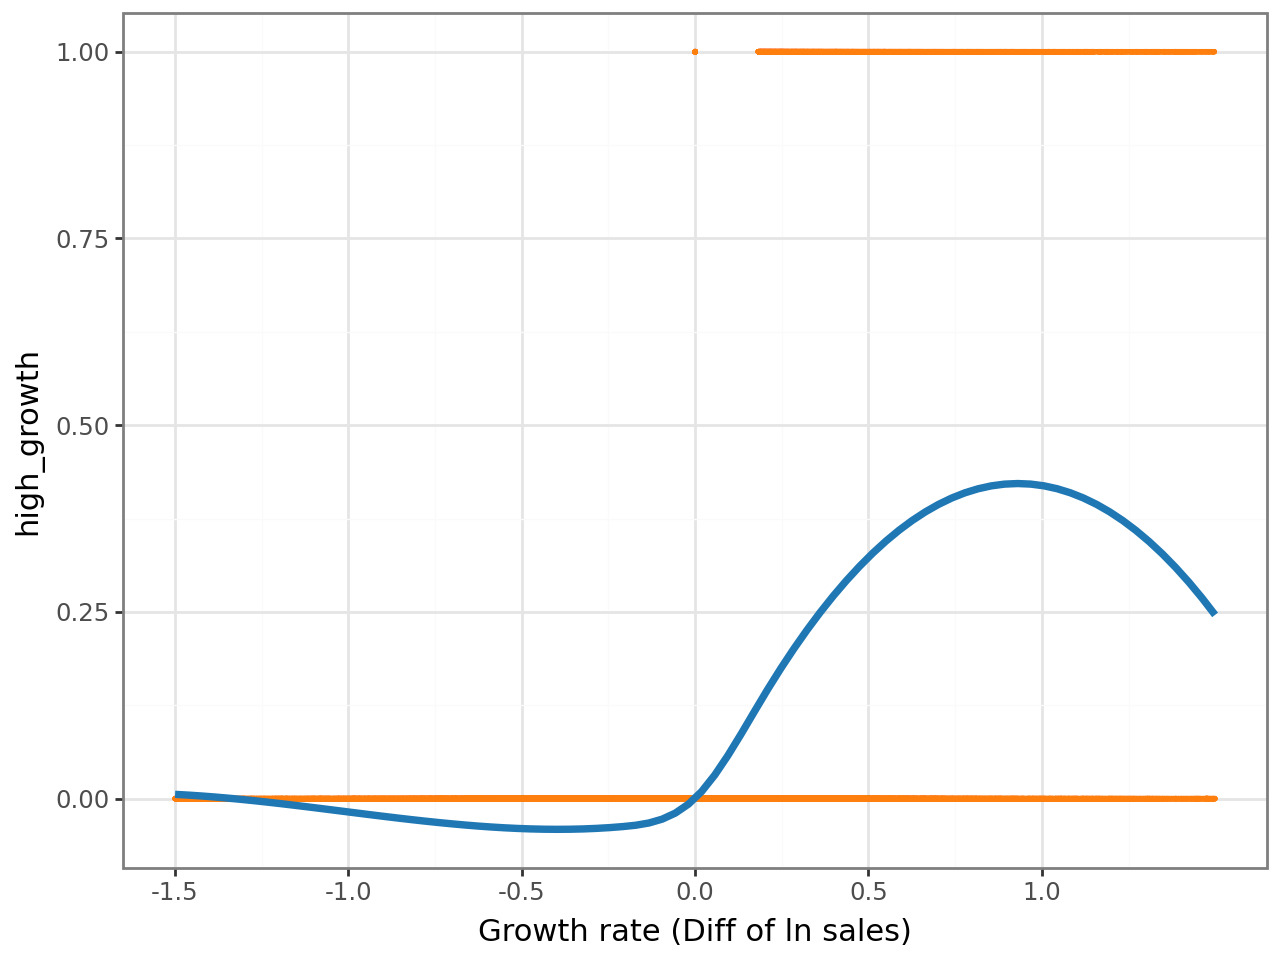

In [161]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="high_growth"))
    + geom_point(size=0.1, color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="high_growth")
    + scale_x_continuous(limits=(-1.5, 1.5), breaks=np.arange(-1.5, 1.5, 0.5))
    + theme_bw()
)


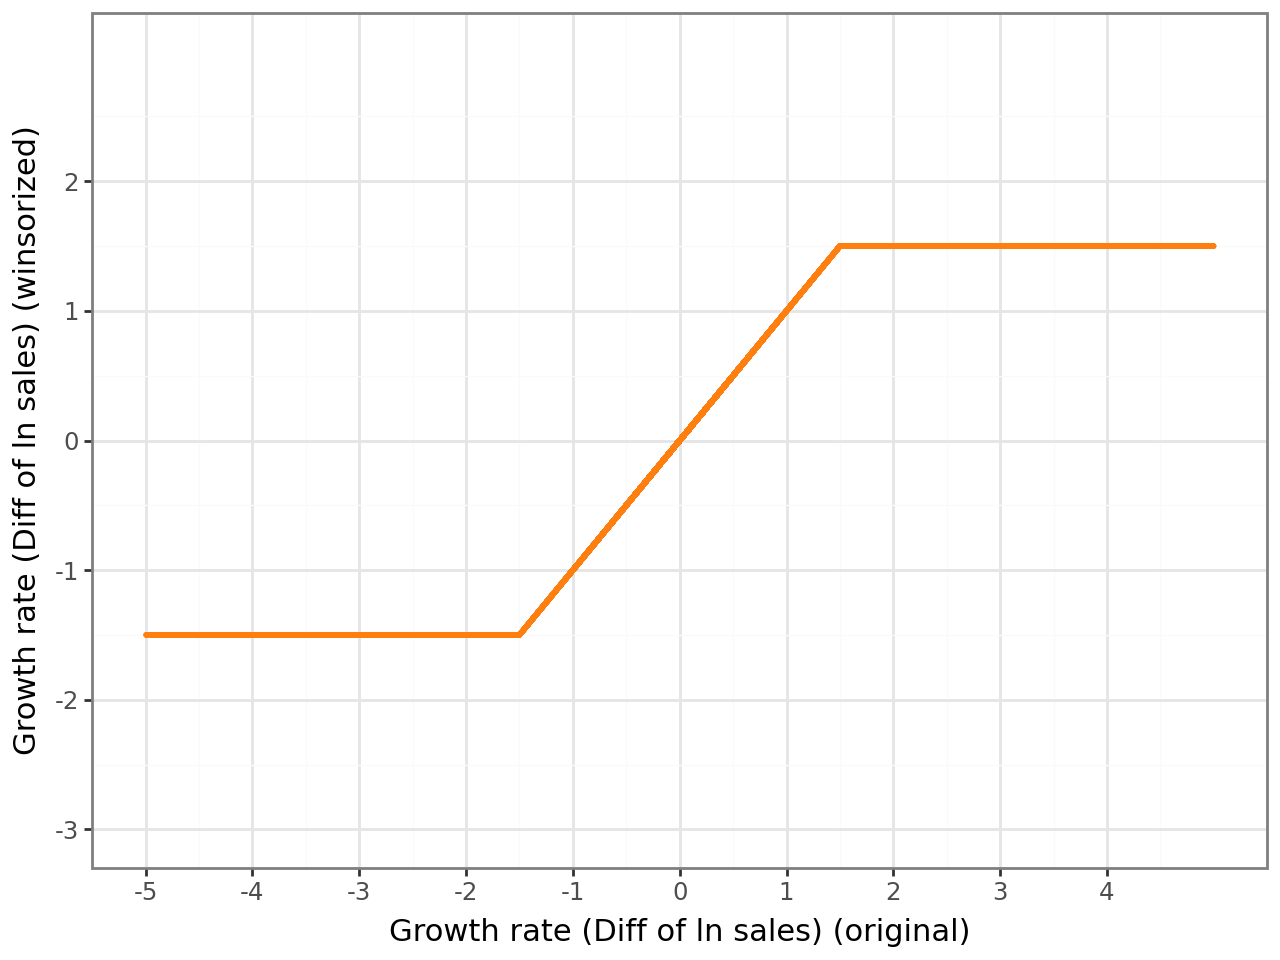

In [162]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="d1_sales_mil_log_mod"))
    + geom_point(size=0.1, color=color[1])
    + labs(
        x="Growth rate (Diff of ln sales) (original)",
        y="Growth rate (Diff of ln sales) (winsorized)",
    )
    + scale_x_continuous(limits=(-5, 5), breaks=np.arange(-5, 5, 1))
    + scale_y_continuous(limits=(-3, 3), breaks=np.arange(-3, 3, 1))
    + theme_bw()
)


In [163]:
data.to_csv("bisnode_firms_clean.csv", index=False)


In [164]:
data["ind"].value_counts()


ind
3.0    96852
2.0    35043
1.0     3223
Name: count, dtype: int64